In [1]:
import os
import tempfile
from pathlib import Path

import mlflow
import pandas as pd
import torch
from azureml.fsspec import AzureMachineLearningFileSystem
from torch import nn

from src.azure_wrap.blob_storage_sdk_v2 import DATASTORE_URI
from src.training.loss_functions import TwoPartLoss
from src.training.transformations import MonotemporalBandExtractor
from src.utils.parameters import EMIT_BANDS
from src.validation.metrics import FalseMetrics, TrueMetrics
from src.validation.validation_metrics_emit import (
    all_error_analysis_plots,
    data_preparation,
    prep_predictions_for_plot,
)

/anaconda/envs/methane-cv-2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the run parameters and metrics

In [2]:
# the run ID (job name) can be copy-pasted from the job's page in the Azure ML studio
run_id = "maroon_card_z5b0s7ccf8"

# get the runs parameters
run = mlflow.get_run(run_id=run_id)
params = run.data.params

BINARY_THRESHOLD = float(params["binary_threshold"])
MSE_MULTIPLIER = float(params["MSE_multiplier"])
model_identifier = params["model_name"]
# note, the validation dataset (and training / test) aren't the actual URIs to the data
# since we have AML download the data to disk the paths get converted to a local path
# we can get the actual paths from the training config if needed.
validation_datasets = [params[x] for x in params if "validation_dataset" in x]

# grab the parent folder from the first dataset so we can glob all the validation data
validation_uri = Path(validation_datasets[0]).parent.as_posix()

print(model_identifier)

models:/torchgeo_pwr_unet_emit/56


In [3]:
# Download run metrics into a temporary directory so we can load into memory
with tempfile.TemporaryDirectory() as dst_path:
    mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path="metrics_per_crop.parquet", dst_path=dst_path)
    metrics_df = pd.read_parquet(os.path.join(dst_path, "metrics_per_crop.parquet"))

metrics_df

,total_samples,total_pixels,total_positives,total_negatives,mean_squared_error,true_positives,true_negatives,false_positives,false_negatives,true_positive_rate,...,signal2noise_ratio,partition,row,total_true_frac,total_predicted_frac,modulate,resize,file,cloud_bucket,transformation
0,1,16384,6,16378,0.000211,0,16378,0,6,0.000000,...,0.005017,0,0,0.032872,0.020843,0.1,0.1,data/aviris/EMIT/validation__emit_aviris_valid...,cloud_bucket_1,modulate_0.1_resize_0.1
1,1,16384,7,16377,0.000881,0,16377,0,7,0.000000,...,0.013176,0,1,0.071566,0.037647,0.1,0.1,data/aviris/EMIT/validation__emit_aviris_valid...,cloud_bucket_1,modulate_0.1_resize_0.1
2,1,16384,1,16383,0.000004,0,16383,0,1,0.000000,...,0.045901,0,2,0.001916,0.016389,0.1,0.1,data/aviris/EMIT/validation__emit_aviris_valid...,cloud_bucket_1,modulate_0.1_resize_0.1
3,1,16384,0,16384,0.000001,0,16384,0,0,NaN,...,NaN,0,3,0.000000,0.015486,0.1,0.1,data/aviris/EMIT/validation__emit_aviris_valid...,cloud_bucket_1,modulate_0.1_resize_0.1
4,1,16384,3,16381,0.000055,0,16381,0,3,0.000000,...,0.135845,0,4,0.011744,0.020561,0.1,0.1,data/aviris/EMIT/validation__emit_aviris_valid...,cloud_bucket_1,modulate_0.1_resize_0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16609,1,16384,75,16309,0.124833,69,16281,28,6,0.920000,...,78.305432,1862,2,5.278001,5.756392,1.0,1.0,data/aviris/EMIT/validation__emit_aviris_valid...,cloud_bucket_50,modulate_1.0_resize_1.0
16610,1,16384,82,16302,0.081227,73,16276,26,9,0.890244,...,129.049401,1862,3,5.300245,5.467449,1.0,1.0,data/aviris/EMIT/validation__emit_aviris_valid...,cloud_bucket_50,modulate_1.0_resize_1.0
16611,1,16384,116,16268,0.151195,115,16245,23,1,0.991379,...,307.734105,1862,4,22.433538,23.345201,1.0,1.0,data/aviris/EMIT/validation__emit_aviris_valid...,cloud_bucket_50,modulate_1.0_resize_1.0
16612,1,16384,31,16353,0.087922,19,16350,3,12,0.612903,...,105.600532,1862,5,1.729512,0.924620,1.0,1.0,data/aviris/EMIT/validation__emit_aviris_valid...,cloud_bucket_50,modulate_1.0_resize_1.0


In [4]:
lossFn = TwoPartLoss(binary_threshold=BINARY_THRESHOLD, MSE_multiplier=MSE_MULTIPLIER)
band_concatenator = MonotemporalBandExtractor(
    band_indices=EMIT_BANDS,
    scaling_factor=0.1,
)
fs = AzureMachineLearningFileSystem(DATASTORE_URI)

validation_dataset = data_preparation(validation_uri, band_extractor=band_concatenator, filesystem=fs)

### Load the model

In [5]:
# Load and prep model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = mlflow.pytorch.load_model(model_identifier, map_location=device)
if isinstance(model, nn.DataParallel):
    model = model.module  # if it's wrapped in DataParallel, unwrap it

model = model.to(device)

### Generate Plots

In [6]:
print("Possible metrics to sort by")
list([k.value for k in TrueMetrics] + [k.value for k in FalseMetrics])

Possible metrics to sort by


['true_negatives',
 'true_positives',
 'true_positive_rate',
 'true_negative_rate',
 'recall',
 'precision',
 'f1_score',
 'false_negatives',
 'false_positives',
 'false_positive_rate',
 'false_negative_rate',
 'average_combined_loss',
 'average_binary_loss',
 'average_conditional_loss',
 'mean_squared_error',
 'signal2noise_ratio']

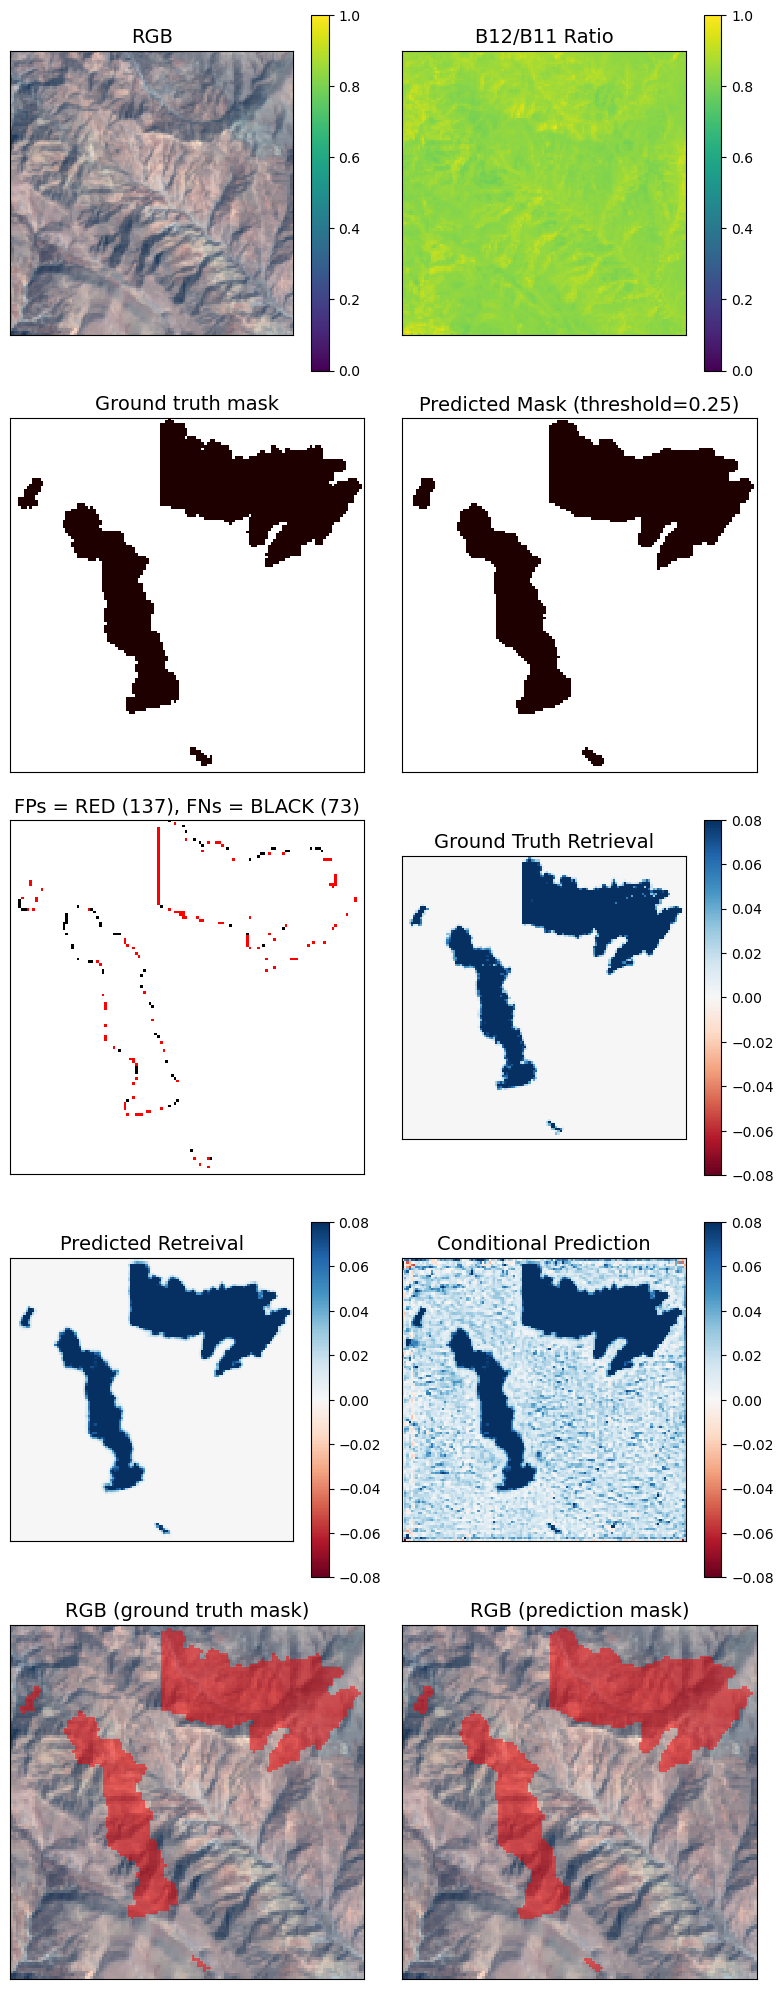

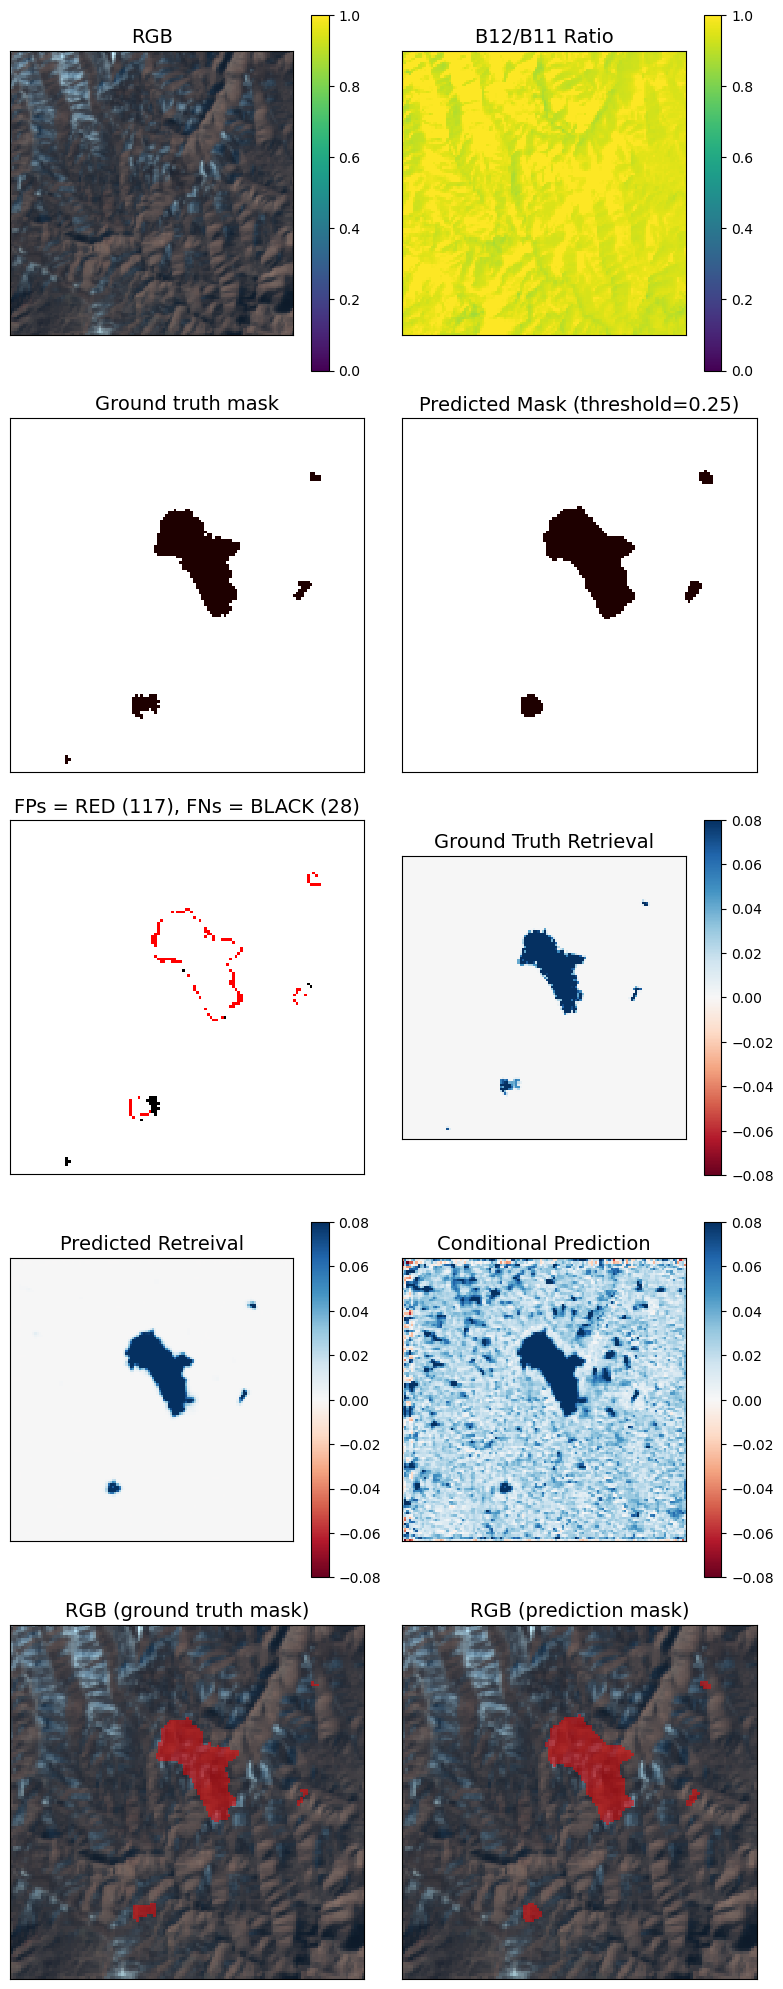

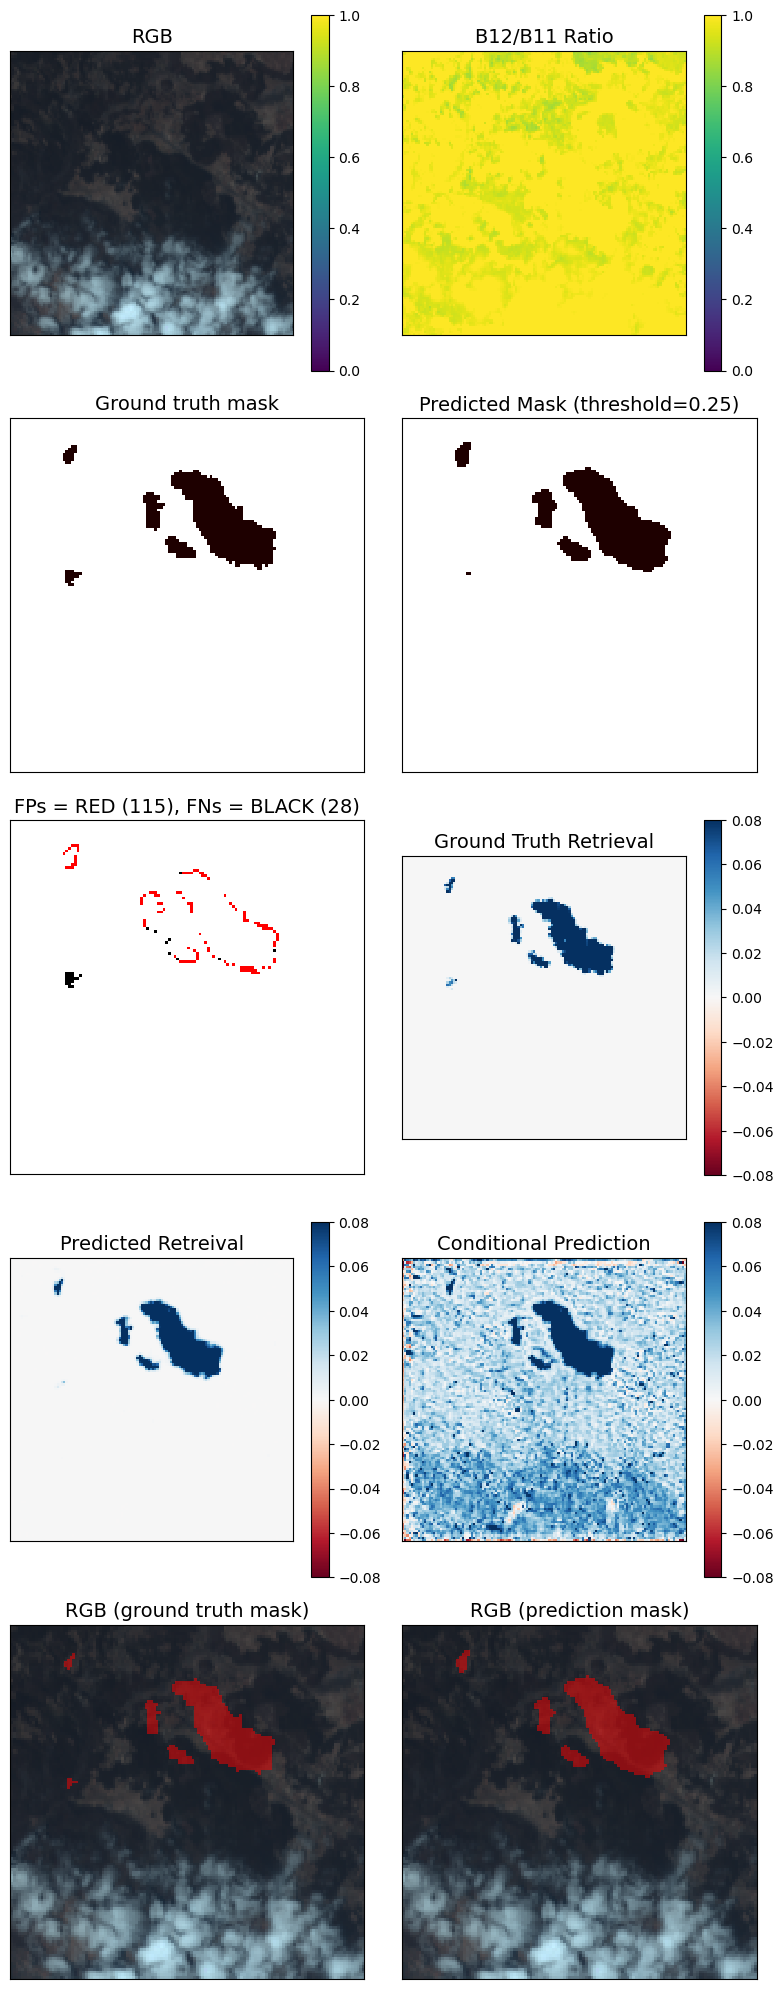

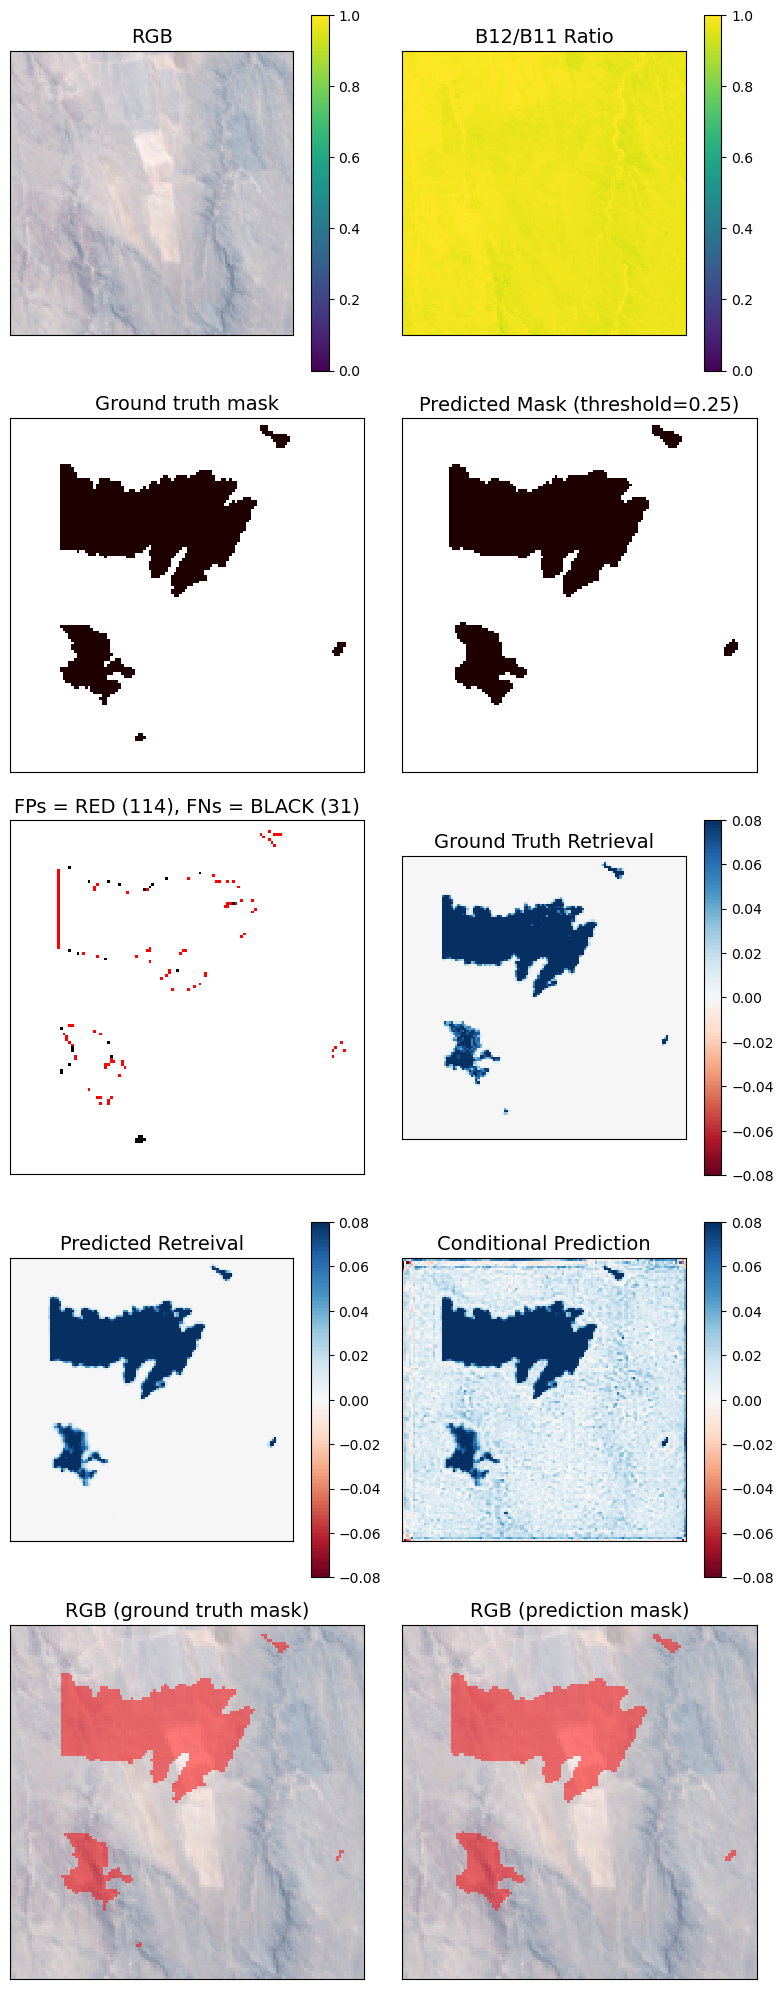

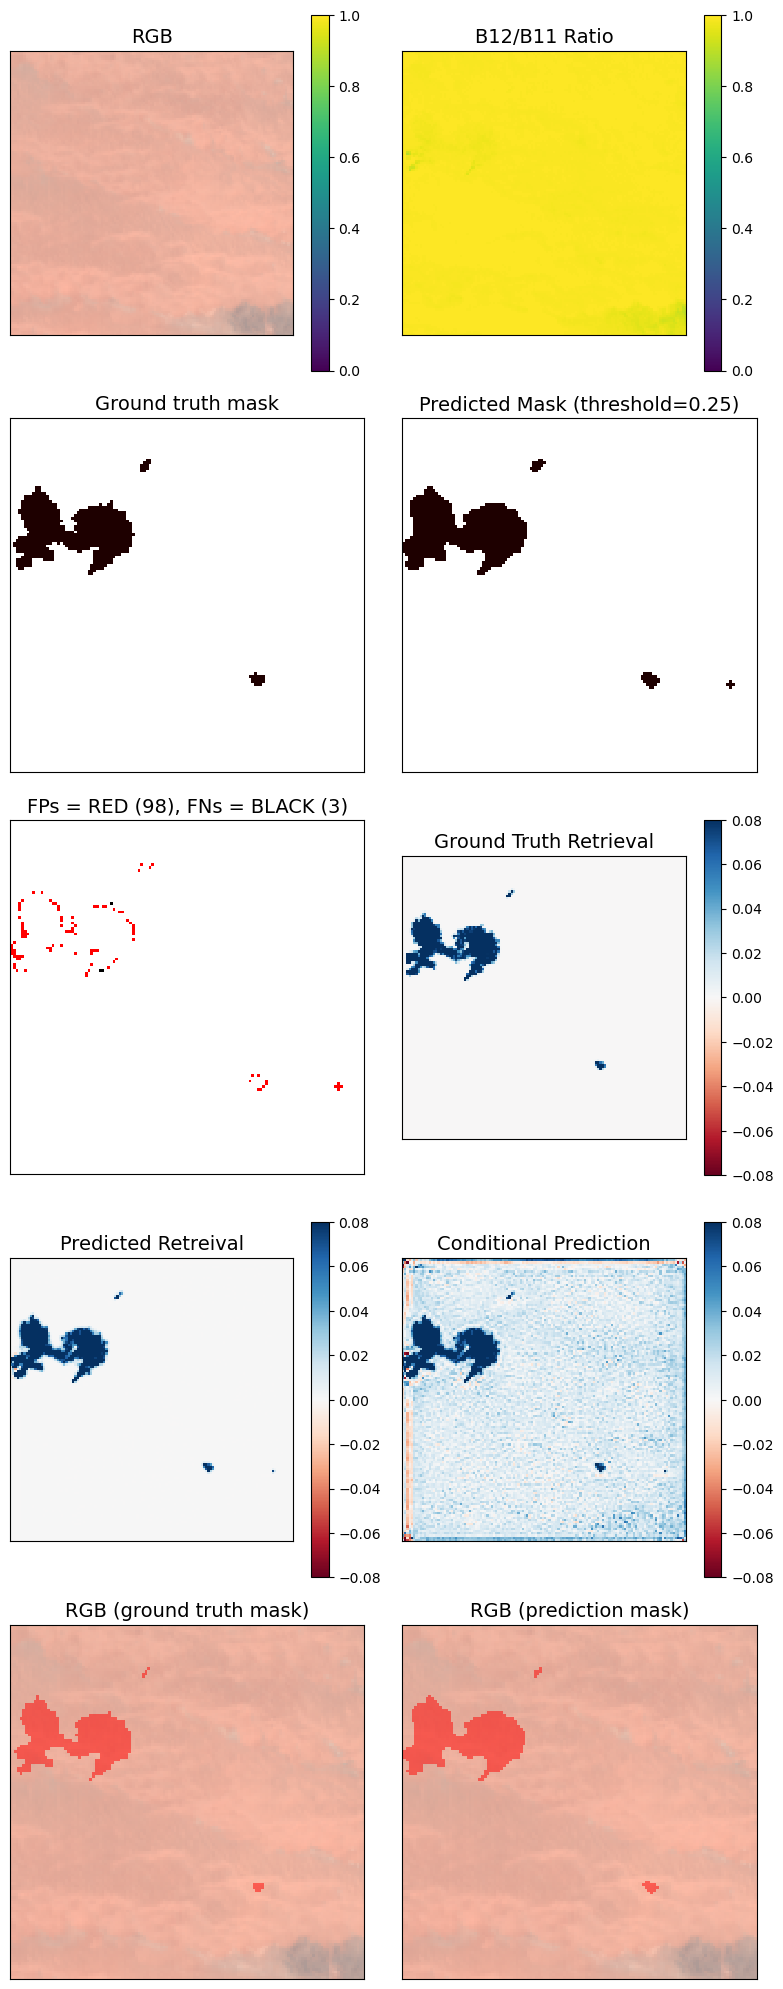

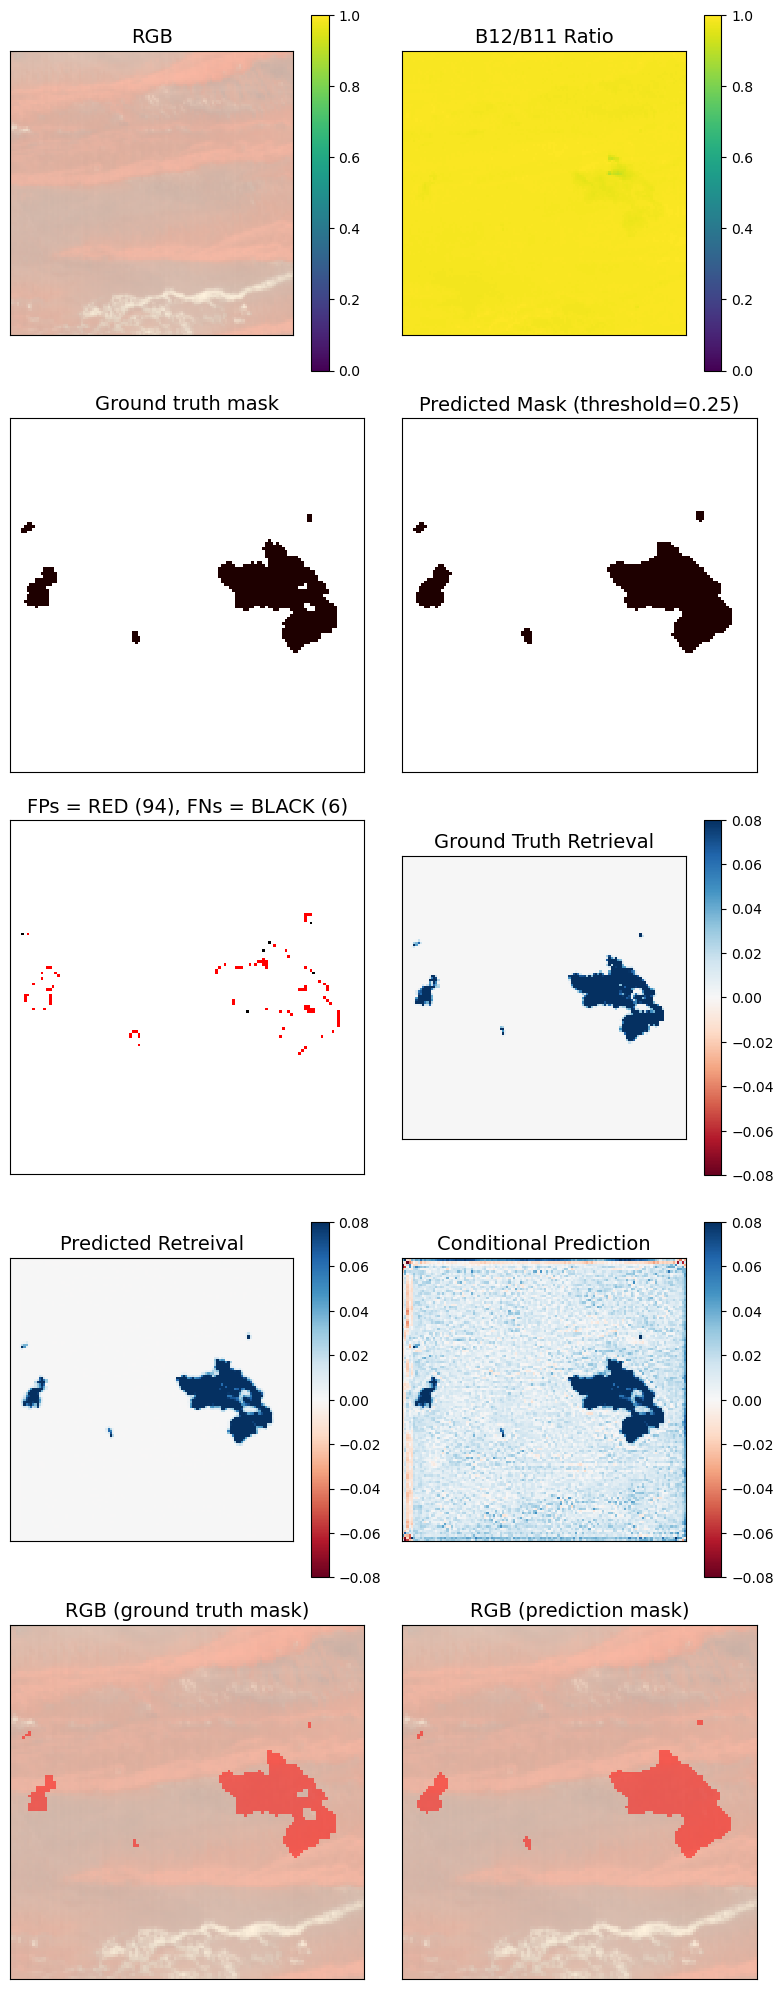

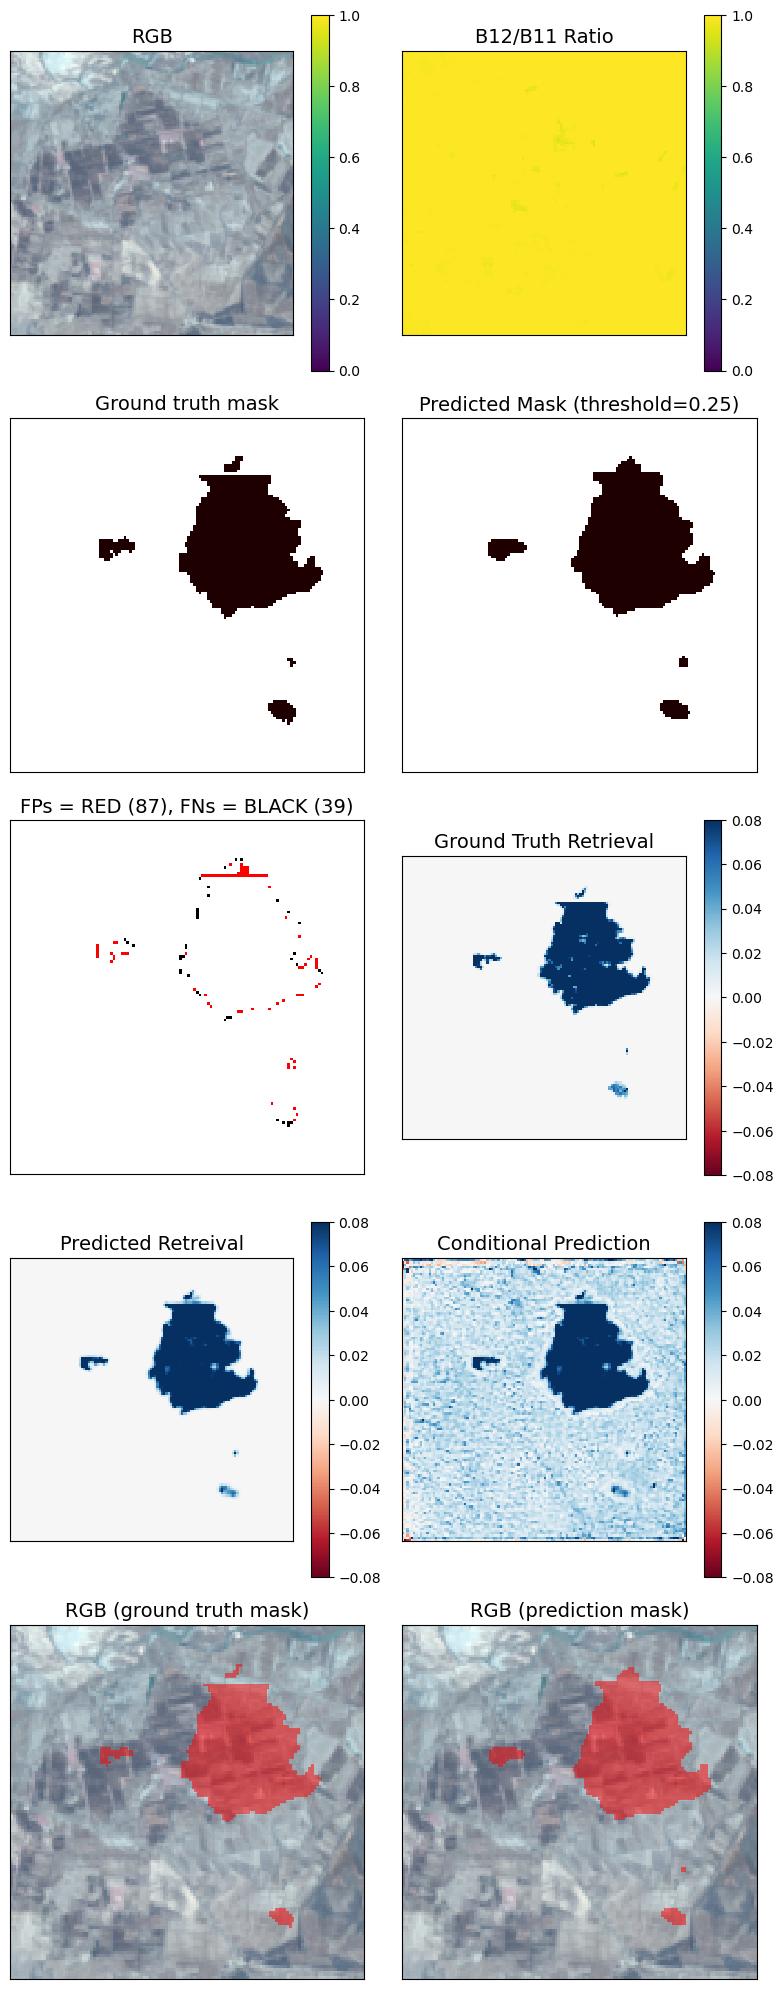

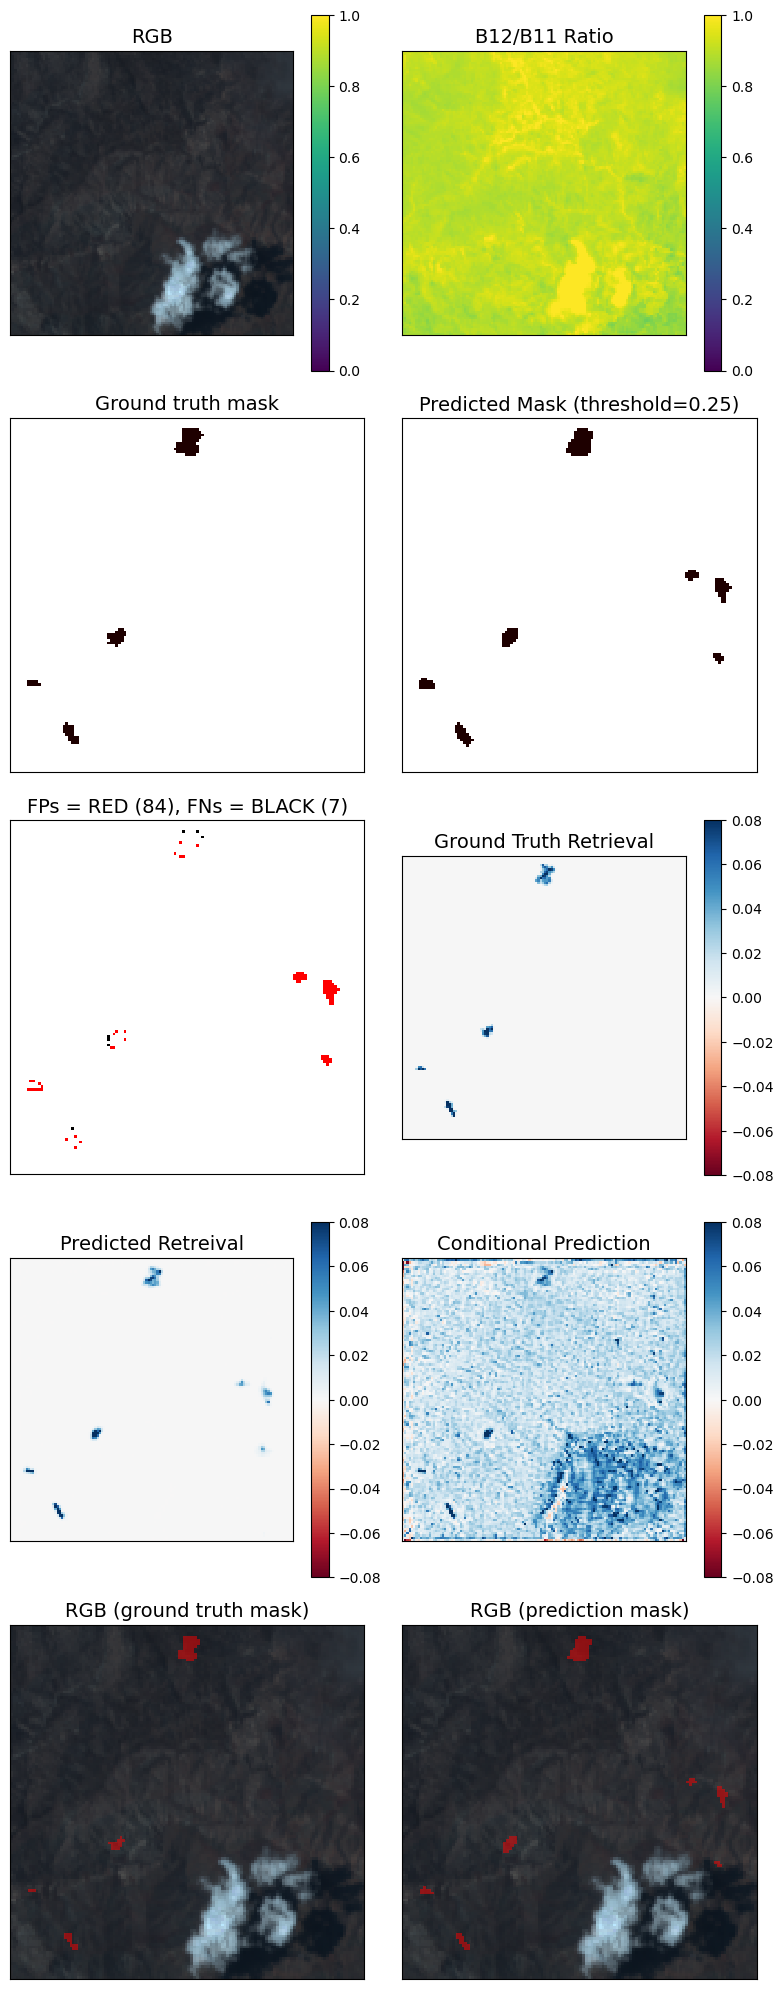

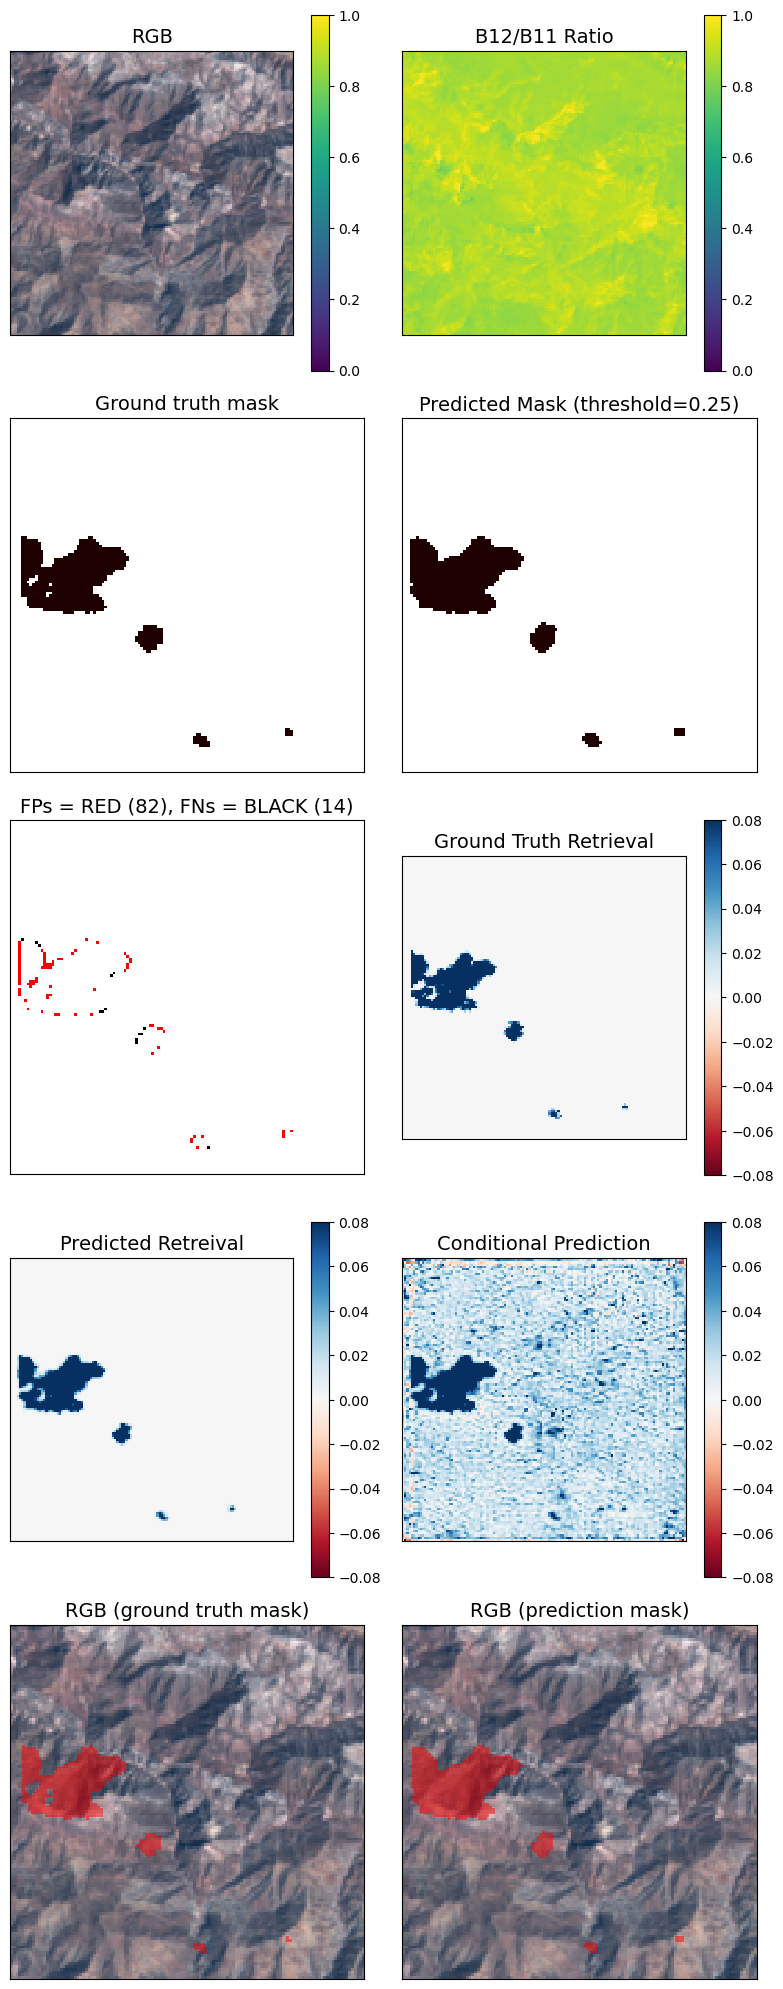

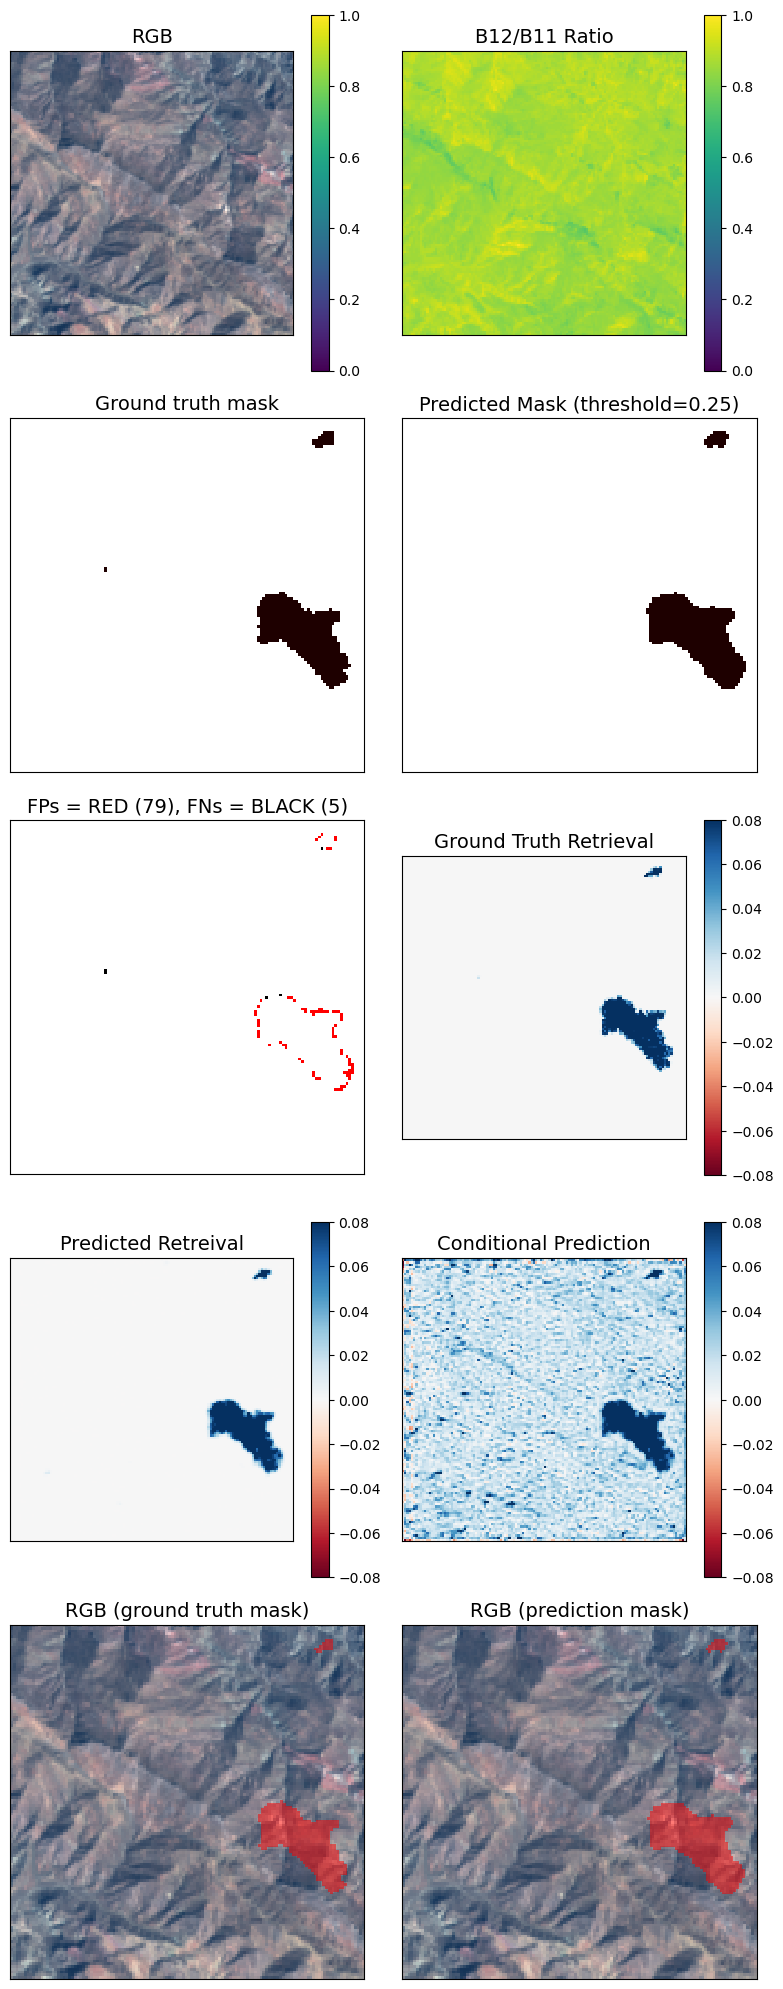

In [13]:
# let's plots come crops (chips)
num_worst_crops = 10
probability_threshold = 0.25
sorting_metric = "false_positives"

ascending = sorting_metric not in set(FalseMetrics)
metrics_df = metrics_df.sort_values(by=sorting_metric, ascending=ascending)

for i in range(num_worst_crops):
    crop = metrics_df.iloc[i]
    index = (crop.partition, crop.row)
    pred = prep_predictions_for_plot(model, validation_dataset.dataset, index, lossFn, probability_threshold)
    fig = all_error_analysis_plots(probability_threshold=probability_threshold, **pred)